---

## Import Libraries and source Data

---

In [162]:
options(warn=-1)


library(ggplot2)
library(gridExtra)
library(tidyr)
library(dplyr)
library(caret)
library(corrplot)
library(readr)
library(knitr)
library(kableExtra)
library(formattable)
library(tm)
library(wordcloud)
library(gridExtra)
library(grid)
library(leaflet)
library(randomForest)
options(knitr.table.format = "html") 

In [164]:
df <- suppressMessages(read_csv("simpsons_script_lines.csv"))

In [139]:
#function to make html table more readable

printable <- function(input){
    
    X <- input
    X$raw_text <- sapply(X$raw_text,truncate)
    X$spoken_words <- sapply(X$spoken_words,truncate)
    X$normalized_text <- sapply(X$normalized_text,truncate)
    return(X)
    
}

truncate <- function(x){
    if(nchar(x)>30){
        paste(strtrim(x,30),"...")
    }else{
        return(x)
    }
}


---

## Dataframe Exploration

---

What does our dataframe look like?

In [140]:
printable(head(df,n=3))

id,episode_id,number,raw_text,timestamp_in_ms,speaking_line,character_id,location_id,raw_character_text,raw_location_text,spoken_words,normalized_text,word_count
9549,32,209,"Miss Hoover: No, actually, it ...",848000,true,464,3,Miss Hoover,Springfield Elementary School,"No, actually, it was a little ...",no actually it was a little of ...,31
9550,32,210,Lisa Simpson: (NEAR TEARS) Whe ...,856000,true,9,3,Lisa Simpson,Springfield Elementary School,Where's Mr. Bergstrom?,wheres mr bergstrom,3
9551,32,211,Miss Hoover: I don't know. Alt ...,856000,true,464,3,Miss Hoover,Springfield Elementary School,I don't know. Although I'd sur ...,i dont know although id sure l ...,22


How big is it?

In [141]:
paste('Rows:',as.character(dim(df)[1]))
paste('Cols:',as.character(dim(df)[2]))

[1] "Rows: 157462"

[1] "Cols: 13"

Column types? 

In [142]:
sapply(df, class)

id         episode_id             number           raw_text 
         "integer"          "integer"          "integer"        "character" 
   timestamp_in_ms      speaking_line       character_id        location_id 
         "integer"        "character"          "integer"          "integer" 
raw_character_text  raw_location_text       spoken_words    normalized_text 
       "character"        "character"        "character"        "character" 
        word_count 
       "character"

Let's simplify some column titles,

In [143]:
colnames(df)[9] <- "character_name"

Get rid of columns we don't need,

In [144]:
df <- subset(df, select = -c(number,timestamp_in_ms, speaking_line, raw_location_text))

And convert word_count to a numeric type

In [145]:
convert <- function(x){
    if(is.na(as.numeric(x))){
        return(NA)
    }else{
        return(as.numeric(x))
    }
}

df$word_count <- sapply(df$word_count,convert)

We may need to do some more work later if we find issues during our analysis, but for now we're done!

---

# Character Line Analysis

---

Lets get a line count for each of the non-null top characters

In [146]:
line_sum <- 

head(
    
    (df %>% 
        filter(character_name != '') %>% 
        group_by(character_name) %>% 
        summarise(n=n()) %>% 
        arrange(desc(n))),
    
n=10)



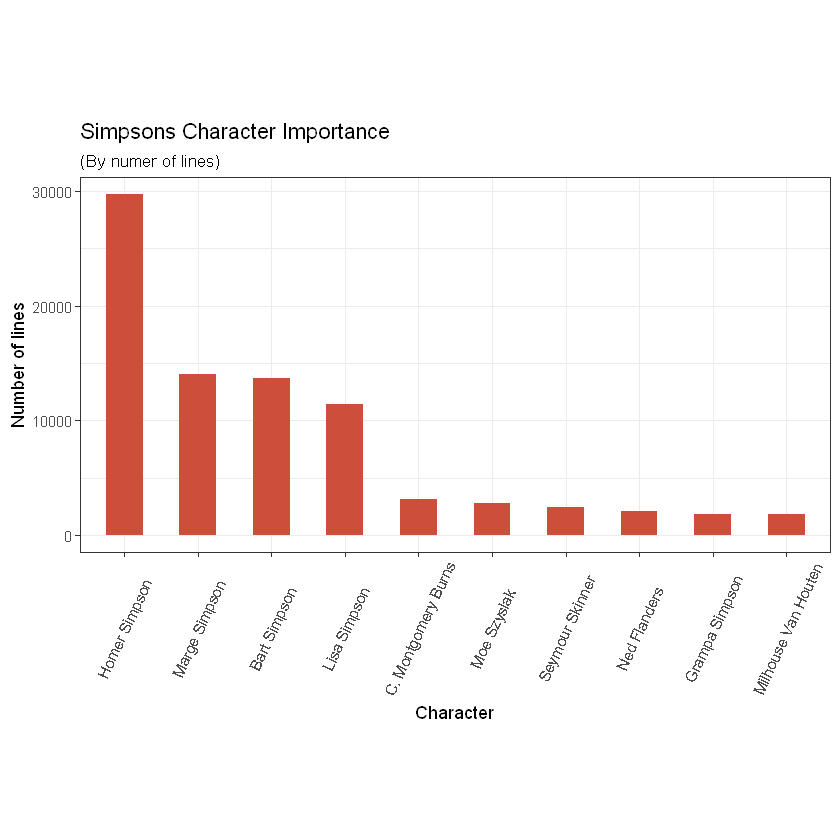

In [147]:
#PLOT

theme_set(theme_bw())

ggplot(data=line_sum, aes(x=reorder(character_name,-n), y=n)) +

    geom_bar(stat="identity", 
             width=.5, 
             fill="tomato3")+

    labs(x="Character", 
         y="Number of lines", 
         title="Simpsons Character Importance",
         subtitle="(By numer of lines)") +

    theme(axis.text.x = element_text(angle=65, vjust=0.5)) +

    theme(aspect.ratio=.5)


We've already seen these results in Gabriela Preda's report,
so instead let's compare line-count with line-length

Our goal is to determine if a character has on average shorter lines, thus affecting their "Importance"

In [148]:
head(
    
    (df %>% 
        filter( character_name != '') %>% 
        group_by(character_name) %>%
        summarise(avg_wordsperline=mean(word_count, na.rm = TRUE )) %>%
        arrange(desc(avg_wordsperline))),
10)

character_name,avg_wordsperline
Ebenezer Urkel,3340.0000
Neil Gaiman,670.8889
Ted Nugent,639.7500
Actor,209.8667
Greta Wolfcastle,173.0000
Female Host,109.4000
NRBQ,82.0000
SIR MIX-A-LOT,72.0000
Johnny Bobby,69.0000
Jack Black,64.0000


Wow, looks like we might have some false data skewing the results

(I don't remember Ebenezer Urkel's lines well, but I'm sure I would if they were 3 THOUSAND words long)

Let's check out these long character lines:

In [149]:
printable(df %>% filter(word_count>200) %>% arrange(desc(word_count)))

id,episode_id,raw_text,character_id,location_id,character_name,spoken_words,normalized_text,word_count
152082,544,"(""SIX FLAGS OVER KRUSTY"" AMUSE ...",NA,4311,NA,851000,true,6521
138005,492,Neil Gaiman: (CHIMING IN) I la ...,5932,3975,Neil Gaiman,788000,true,5933
138021,492,"(""TWEEN LIT INC."" MEETING ROOM ...",NA,3975,NA,872000,true,5933
136529,487,"(""top Chef"" Kitchen: Int. ""top ...",NA,3934,NA,174000,true,5879
136531,487,Marge Simpson: Thank you! This ...,1,3934,Marge Simpson,185000,true,5879
139200,496,Homer Simpson: (PUZZLED NOISE) ...,2,4018,Homer Simpson,1180000,true,5014
139208,496,Ted Nugent: HAIL TO ME / I'M T ...,5014,4018,Ted Nugent,1267000,true,5014
96297,334,"(""HEADBUTT"" SET: INT. ""HEADBUT ...",NA,2804,NA,648000,true,4185
96304,334,Homer Simpson: (MOUTH FULL GAS ...,2,2804,Homer Simpson,694000,true,4185
96306,334,Marge Simpson: (STILL MAD) I'l ...,1,2804,Marge Simpson,701000,true,4185


Ah, look at the word counts.  This is all incorrect data, and it explains the high averages for Ebenezer Urkel, Neil Gaiman, Ted Nugent and others, especially since the average is being take over so few lines.

I see a patern: all rows say "true" under normalized_text.   Let's see if my speculation is correct:

In [150]:
printable(df %>% filter(normalized_text=="true"))

id,episode_id,raw_text,character_id,location_id,character_name,spoken_words,normalized_text,word_count
21349,72,"(""the Lucky Stiff"" Funeral Hom ...",NA,761,NA,321000,true,990
21353,72,Patty Bouvier: I'll keep this ...,10,761,Patty Bouvier,513000,true,22
23210,78,Homer Simpson: True.,2,826,Homer Simpson,True.,true,1
23212,78,Homer Simpson: True.,2,826,Homer Simpson,True.,true,1
50532,179,"(""MAD"" RECEPTION AREA: Int. ""M ...",NA,1663,NA,1004000,true,8
50537,179,Bart Simpson: (DISAPPOINTED) O ...,8,1663,Bart Simpson,1054000,true,2290
66294,232,"(""SPRINGFIELD SQUARES"" GAMESHO ...",NA,2002,NA,617000,true,33
66298,232,Disco Stu: Disco Stu's gonna g ...,1867,2002,Disco Stu,640000,true,211
66300,232,Disco Stu: I can dig it. Hit m ...,1867,2002,Disco Stu,646000,true,211
66311,232,Homer Simpson: (HURT) Flavor o ...,2,2002,Homer Simpson,677000,true,2580


Yep, all false data.  If we dump all of it, how much damage are we doing?

In [151]:
x <- dim(df %>% filter(normalized_text=='true'))[1]

print(paste("Rows:",as.character(x)))

y <- round((100*(x/157462)),2)

print(paste("Percentage of df:",as.character(y),"%"))


[1] "Rows: 64"
[1] "Percentage of df: 0.04 %"


*Laaaaaaater*

![title](https://assets-cdn.github.com/images/icons/emoji/unicode/270c.png)

In [152]:
df <- df %>% filter(normalized_text !='true')

In [153]:
printable(head(df %>% arrange(desc(word_count)),10))

id,episode_id,raw_text,character_id,location_id,character_name,spoken_words,normalized_text,word_count
22701,76,Grampa Simpson: One trick is t ...,31,51,Grampa Simpson,One trick is to tell them stor ...,one trick is to tell them stor ...,122
134211,478,"""Randy Newman"": It was not! Wh ...",5807,3869,Randy Newman,It was not! Who else in here's ...,it was not who else in heres g ...,116
3069,10,Homer Simpson: Quiet! I have s ...,2,171,Homer Simpson,Quiet! I have something to say ...,quiet i have something to say ...,114
52015,184,"Homer Simpson: Scully, you're ...",2,583,Homer Simpson,"Scully, you're cut. Ehhh, Broo ...",scully youre cut ehhh brooks g ...,111
99981,347,David Silverman: David Silverm ...,4349,2906,David Silverman,"David Silverman here, Supervis ...",david silverman here supervisi ...,111
156167,560,"SAMMY HAGAR: So there I am, in ...",6685,4417,SAMMY HAGAR,"So there I am, in Easter Islan ...",so there i am in easter island ...,110
27895,94,James Woods: (AGITATED) To-Ton ...,1337,136,James Woods,"To-Toni, Toni, do-- you're my ...",to-toni toni do-- youre my age ...,106
28412,96,Kent Brockman: (CALMLY) Ladies ...,211,1014,Kent Brockman,"Ladies and gentlemen, we've ju ...",ladies and gentlemen weve just ...,106
135363,482,Ewell Freestone: (SING) AND TH ...,5846,3910,Ewell Freestone,AND THE YEAR'S FOURTH PEACH / ...,and the years fourth peach is ...,105
15882,52,Singers: WELL MR. BURNS HAD DO ...,276,572,Singers,WELL MR. BURNS HAD DONE IT / T ...,well mr burns had done it the ...,103


This looks SO much better.  We're ready to look at some averages!

In [154]:
head(
    
    (df %>% 
        filter( character_name != '') %>% 
        group_by(character_name) %>%
        summarise(avg_wordsperline=mean(word_count, na.rm = TRUE )) %>%
        arrange(desc(avg_wordsperline))),
10)

character_name,avg_wordsperline
NRBQ,82.00
SIR MIX-A-LOT,72.00
Johnny Bobby,69.00
Jack Black,64.00
David Silverman,61.00
Randy Jackson,59.00
Ellen DeGeneres,58.00
Randy Newman,57.75
SAMMY HAGAR,52.00
TRUONG,52.00


It makes sense that celebrities characters have the longest lines.  Writer's probably to squeeze the most dialog out of their short cameos

Now back to the *original question*: what does this mean for our main characters?

In [155]:
line_counts <- 

head(
    
    (df %>% 
        filter((character_name != '') & (word_count!= '')) %>% 
        group_by(character_name) %>% 
        summarise(total_words = sum(word_count)) %>% 
        arrange(desc(total_words))),
 
 n=10)

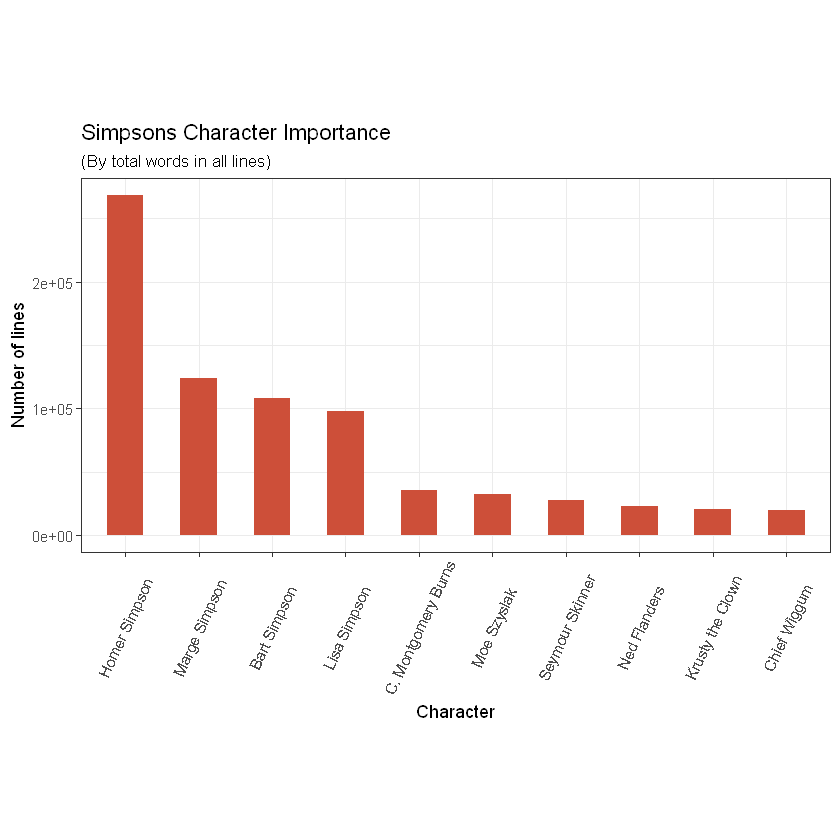

In [156]:
theme_set(theme_bw())

ggplot(data=line_counts, aes(x=reorder(character_name,-total_words), y=total_words)) +

    geom_bar(stat="identity", 
             width=.5, 
             fill="tomato3")+

    labs(x="Character", 
         y="Number of lines", 
         title="Simpsons Character Importance",
         subtitle="(By total words in all lines)") +

    theme(axis.text.x = element_text(angle=65, vjust=0.5)) +

    theme(aspect.ratio=.5)

Doesn't change much for our top 8 characters, however we have an appearance of 2 new characters: *Krusty* and *Chief Wiggum*.  Maybe they have longer lines than the characters they replaced (Grandpa and Millhouse)

In [157]:
df %>% 
    filter( character_name == "Krusty the Clown"| 
           character_name == "Chief Wiggum" | 
           character_name == "Grampa Simpson" | 
           character_name == 'Milhouse Van Houten' ) %>% 
    group_by(character_name) %>%
    summarise(avg_wordsperline=mean(word_count, na.rm = TRUE )) %>%
    arrange(desc(avg_wordsperline))


character_name,avg_wordsperline
Krusty the Clown,12.146154
Chief Wiggum,11.162192
Grampa Simpson,10.801111
Milhouse Van Houten,8.285879


We we're right!  Although you would think the longest line in the whole show belonging to Grampa would help is average a little more.

https://www.youtube.com/watch?v=5Rzao52ndNA

This makes me wonder about Grandpa's distribution vs the other's

In [158]:
plot1 <- df %>% filter( character_name == "Grampa Simpson" & word_count != '' & id != 22701 ) #rid of longest line
plot2 <- df %>% filter( character_name == "Milhouse Van Houten" & word_count != '')
plot3 <- df %>% filter( character_name == "Krusty the Clown" & word_count != '')
plot4 <- df %>% filter( character_name == "Chief Wiggum" & word_count != '')

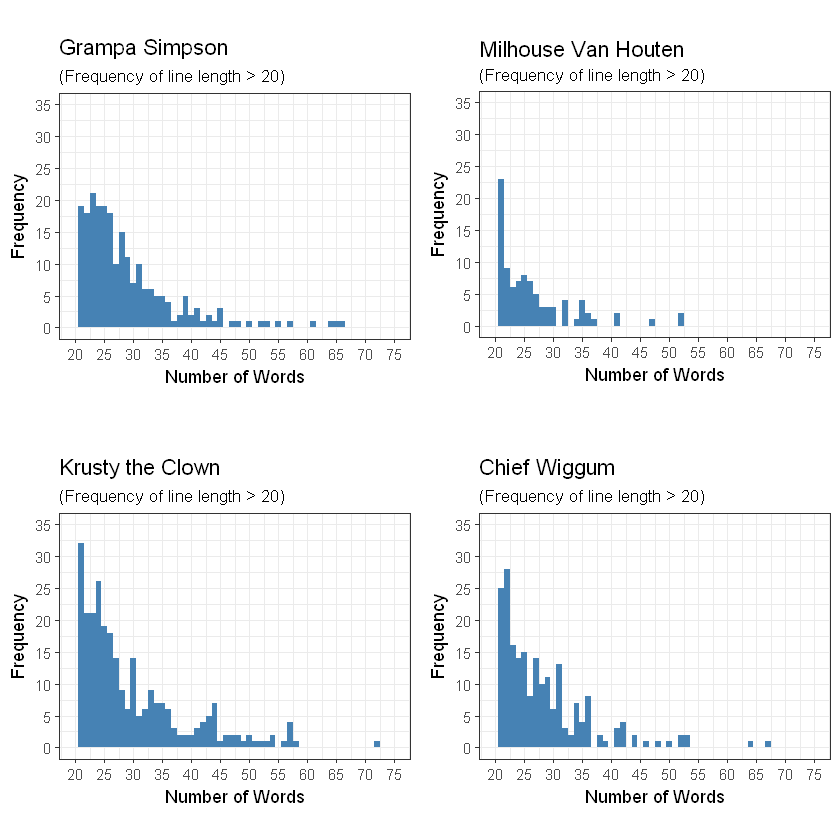

In [159]:
require(gridExtra)

theme_set(theme_bw())

p1 <- ggplot(data=plot1, aes(x=word_count))+
    geom_histogram(binwidth=1, fill="steelblue")+
    labs(x="Number of Words", 
         y="Frequency", 
         title="Grampa Simpson",
         subtitle="(Frequency of line length > 20)") +
    scale_y_continuous(limits=c(0,35),
                       breaks=(5*(0:7)))+
    scale_x_continuous(limits=c(20,75),
                       breaks=(5*(4:15)))+
    theme(aspect.ratio=.7)

p2 <- ggplot(data=plot2, aes(x=word_count))+
    geom_histogram(binwidth=1, fill="steelblue")+
    labs(x="Number of Words", 
         y="Frequency", 
         title="Milhouse Van Houten",
         subtitle="(Frequency of line length > 20)") +
    scale_y_continuous(limits=c(0,35),
                       breaks=(5*(0:7)))+
    scale_x_continuous(limits=c(20,75),
                       breaks=(5*(4:15)))+
    theme(aspect.ratio=.7)

p3 <- ggplot(data=plot3, aes(x=word_count))+
    geom_histogram(binwidth=1, fill="steelblue")+
    labs(x="Number of Words", 
         y="Frequency", 
         title="Krusty the Clown ",
         subtitle="(Frequency of line length > 20)") +
    scale_y_continuous(limits=c(0,35),
                       breaks=(5*(0:7)))+
    scale_x_continuous(limits=c(20,75),
                       breaks=(5*(4:15)))+
    theme(aspect.ratio=.7)

p4 <- ggplot(data=plot4, aes(x=word_count))+
    geom_histogram(binwidth=1, fill="steelblue")+
    labs(x="Number of Words", 
         y="Frequency", 
         title="Chief Wiggum",
         subtitle="(Frequency of line length > 20)") +
    scale_y_continuous(limits=c(0,35),
                       breaks=(5*(0:7)))+
    scale_x_continuous(limits=c(20,75),
                       breaks=(5*(4:15)))+
    theme(aspect.ratio=.7)

grid.arrange(p1,p2,p3,p4)